First, I will read the data. 
**These two folders must exist at the same path of this notebook:**
- '.\\Training Data\\Normal'
- '.\\Training Data\\ASD'
The dimention of data is tricky. For each (subject, voxel) we have a signal of intensities over time. I need to have one single value representing the signal to be able to build models. I decided to represent each signal with its `mean` value over time and continue this experiment. The results are at the end.

In [90]:
import pandas as pd
import os
import glob

all_subjects = pd.DataFrame()
y = pd.DataFrame()

path = '.\\Training Data\\Normal'
csv_files = glob.glob(os.path.join(path, "*.csv"))
# loop over the list of csv files
for csv_file in csv_files: 
    # read the csv file
    d = pd.read_csv(csv_file, sep=",", header=0, index_col=0)
    d2 = d.mean(axis=0)
    all_subjects = pd.concat([all_subjects, d2], axis=1)

normal_labels = pd.Series([0.0 for idx in range(all_subjects.shape[1])])
y = pd.concat([y, normal_labels])

path = '.\\Training Data\\ASD'
csv_files = glob.glob(os.path.join(path, "*.csv"))
# loop over the list of csv files
for csv_file in csv_files: 
    # read the csv file
    d = pd.read_csv(csv_file, sep=",", header=0, index_col=0)
    d2 = d.mean(axis=0)
    all_subjects = pd.concat([all_subjects, d2], axis=1)

asd_labels = pd.Series([1.0 for idx in range(all_subjects.shape[1] - y.shape[0])])
y = pd.concat([y, asd_labels])

In [91]:
X = all_subjects.T
X.index = [idx for idx in range(X.shape[0])]

y.index = [idx for idx in range(y.shape[0])]

In [104]:
# merge data
X_y = pd.concat([X, y], axis=1)
X_y.rename(columns = {0:'y'}, inplace = True)

In [105]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

In [125]:
from sklearn.linear_model import LogisticRegression

l_regression_clf = LogisticRegression(random_state=0)
_ = l_regression_clf.fit(train_X, train_y.values.ravel())

In [126]:
from sklearn.metrics import mean_absolute_error

l_regression_predictions = l_regression_clf.predict(val_X)
l_regression_mae = mean_absolute_error(l_regression_predictions, val_y)
l_regression_score = l_regression_clf.score(val_X, val_y)

print(f"Validation MAE of linear reression model: {l_regression_mae}")
print(f"Validation Score of linear reression model: {l_regression_score}")

Validation MAE of linear reression model: 0.6
Validation Score of linear reression model: 0.4


Accuracy of 0.4. Worse than tossing a coin!
I will calculate mutual information of features and target variables next.

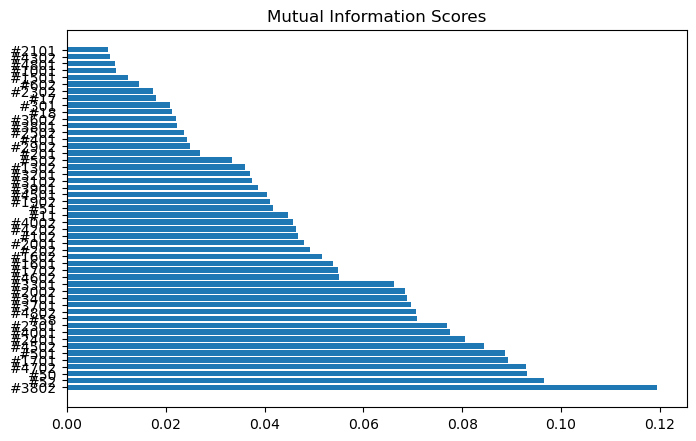

In [136]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

mi_scores = mutual_info_regression(train_X, train_y.values.ravel())
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)

top_50_mi_scores = mi_scores.sort_values(ascending=False)[:50]
width = np.arange(len(top_50_mi_scores))
ticks = list(top_50_mi_scores.index)
plt.figure(dpi=100, figsize=(8, 5))
plt.barh(width, top_50_mi_scores)
plt.yticks(width, ticks)
_ = plt.title("Mutual Information Scores")

I will rebuild the model for top 2 to top 50 scored features and evaluate them next.

In [155]:
best_accuracy = -1
best_top_features_count = None
best_model = None
for features_count in range(1, 51):
    features = top_50_mi_scores[:features_count].index
    new_clf = LogisticRegression(random_state=0)
    _ = new_clf.fit(train_X[features], train_y.values.ravel())
    new_score = new_clf.score(val_X[features], val_y)
    if new_score > best_accuracy:
        best_accuracy = new_score
        best_top_features_count = features_count
        best_model = new_clf
        
print(f"Best accuracy: {best_accuracy}")
print(f"Best top features count: {best_top_features_count}")

Best accuracy: 0.56
Best top features count: 4


In [158]:
features = top_50_mi_scores[:best_top_features_count].index
train_accuracy = best_model.score(train_X[features], train_y)
print(f"Accuracy on train data: {train_accuracy}")

Accuracy on train data: 0.6933333333333334


Overfitting is one problem. But 0.7 accuracy is not acceptable neither. I will try Random Forest model on top 50 scored features first.

In [159]:
from sklearn.ensemble import RandomForestClassifier

features = top_50_mi_scores.index
forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(train_X[features], train_y.values.ravel())
forest_train_accuracy = forest_model.score(train_X[features], train_y)
forest_val_accuracy = forest_model.score(val_X[features], val_y)

print(f"Random Forest train accuracy: {forest_train_accuracy}")
print(f"Random Forest validation accuracy: {forest_val_accuracy}")

Random Forest train accuracy: 1.0
Random Forest validation accuracy: 0.28


I will grid search for these parameters: top scored features (1, 10), max_leaf_nodes [100, 500, 750, 1000, 1500, 5000]

In [176]:
best_forest_accuracy = -1
best_forest_top_features_count = None
best_forest_model = None
max_leaf_nodes_experiments = [100, 500, 750, 1000, 1500, 5000]
for features_count in range(1, 10):
    for max_leaf_nodes in max_leaf_nodes_experiments:
        features = top_50_mi_scores[:features_count].index
        new_clf = RandomForestClassifier(random_state=1).fit(train_X[features], train_y.values.ravel())
        new_score = new_clf.score(val_X[features], val_y)
        if new_score > best_forest_accuracy:
            best_forest_accuracy = new_score
            best_forest_top_features_count = features_count
            best_forest_model = new_clf
            
print(f"Best Random Forest validation accuracy: {best_forest_accuracy}")
print(f"Best Random Forest features count: {best_forest_top_features_count}")

Best Random Forest validation accuracy: 0.52
Best Random Forest features count: 4


I plot the accuracy with respect to max_leaf_nodes to see if I can improve accracy.

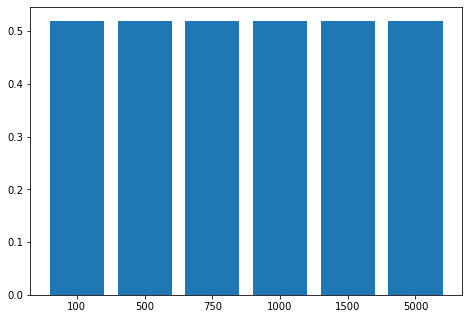

In [179]:
accracy_experiments = []
for max_leaf_nodes in max_leaf_nodes_experiments:
    features = top_50_mi_scores[:best_forest_top_features_count].index
    new_clf = RandomForestClassifier(random_state=1).fit(train_X[features], train_y.values.ravel())
    new_score = new_clf.score(val_X[features], val_y)
    accracy_experiments.append(new_score)
experiments = [str(e) for e in max_leaf_nodes_experiments]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(experiments, accracy_experiments)
plt.show()

I should change the value for experiments.

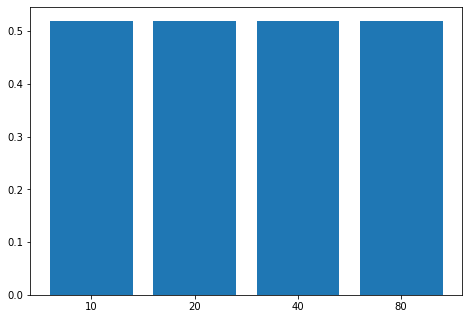

In [180]:
max_leaf_nodes_experiments = [10, 20, 40, 80]
accracy_experiments = []
for max_leaf_nodes in max_leaf_nodes_experiments:
    features = top_50_mi_scores[:best_forest_top_features_count].index
    new_clf = RandomForestClassifier(random_state=1).fit(train_X[features], train_y.values.ravel())
    new_score = new_clf.score(val_X[features], val_y)
    accracy_experiments.append(new_score)
experiments = [str(e) for e in max_leaf_nodes_experiments]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(experiments, accracy_experiments)
plt.show()

It did not matter. I think random forest models is not a good candidate to consider anymore.
So, I got 0.56 accuracy with a linear regression model.
The decision to choose mean value of signals to build models on is not a good choice. That's because I could not come up with another solution.

That's the end of experiment.
